# Latent Space Exploration of Icons with a VAE
#
**Goal:** Train a Variational Autoencoder (VAE) on rasterized Heroicons to:
1. Learn a compressed latent representation.
2. Generate new icon variations by sampling from the latent space.
3. Create smooth visual transitions (interpolations) between existing icons.

**Source Data:** Preprocessed Heroicons (rasterized to PNG, 64x64 binary ). Data in directory `DATA_DIR`.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import save_image, make_grid

from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

import logging
from tqdm.notebook import tqdm # Progress bars for notebooks
import wandb

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


## Phase 2: Configuration & Setup

Here we define hyperparameters, configure the device (CPU/GPU), set up data paths, and initialize Weights & Biases for experiment tracking.


In [3]:
#Configuration

# Data Params
DATA_DIR = '/Users/shrutisaagar/msai/3/genai/icon_gen/processed_icons'
IMG_SIZE = 64
IMG_CHANNELS = 1

# VAE Model Params
LATENT_DIM = 32
HIDDEN_DIMS = [32, 64, 128, 256]

# Training Params
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
BETA = 1.0 # Weight for KL divergence term in loss (Beta-VAE parameter)

# Environment & Saving
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
MODEL_SAVE_PATH = 'vae_heroicons_model.pth'
RESULTS_DIR = 'vae_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

WANDB_PROJECT = 'vae-heroicons-notebook'
WANDB_ENTITY = None 

logging.info(f"Using device: {DEVICE}")
logging.info(f"Configuration loaded. Latent Dim: {LATENT_DIM}, Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}")


2025-05-04 00:57:17,808 - INFO - Using device: cpu
2025-05-04 00:57:17,809 - INFO - Configuration loaded. Latent Dim: 32, Epochs: 50, Batch Size: 32


In [4]:

# Initialize Weights & Biases
try:
    wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        config={
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "latent_dim": LATENT_DIM,
            "hidden_dims": HIDDEN_DIMS,
            "img_size": IMG_SIZE,
            "beta": BETA,
            "dataset": DATA_DIR,
            "seed": SEED
        }
    )
    logging.info("Weights & Biases initialized successfully.")

    wandb.define_metric("epoch")
    wandb.define_metric("train/loss", step_metric="epoch", summary="min")
    wandb.define_metric("train/recon_loss", step_metric="epoch", summary="min")
    wandb.define_metric("train/kld_loss", step_metric="epoch", summary="min")

except Exception as e:
    logging.error(f"Could not initialize Weights & Biases: {e}")
    raise e

wandb: Currently logged in as: t3j1d7 (t3j1d7-northwestern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-05-04 00:57:18,828 - INFO - Weights & Biases initialized successfully.


### Data Loading

We define a custom `Dataset` to load our processed PNG icons and a `DataLoader` to handle batching and shuffling efficiently.


In [13]:

# Custom Dataset class for icons
class IconDataset(Dataset):
    """Dataset for loading processed icon images."""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = glob.glob(os.path.join(data_dir, '*.png')) + \
                           glob.glob(os.path.join(data_dir, '*.PNG'))
        self.transform = transform
        if not self.image_files:
            logging.error(f"No PNG files found in {data_dir}. Please check the path.")
            raise FileNotFoundError(f"No PNG images found in directory: {data_dir}")
        else:
             logging.info(f"Found {len(self.image_files)} images in {data_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert('L')
            if self.transform:
                image = self.transform(image)

            return image.float()
        except Exception as e:
            logging.error(f"Error loading image {img_path}: {e}. Skipping.")
            return torch.zeros((IMG_CHANNELS, IMG_SIZE, IMG_SIZE)).float()

logging.info("Setting up dataset and dataloader...")

transform = ToTensor()
dataset = IconDataset(data_dir=DATA_DIR, transform=transform)

train_loader = DataLoader(dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True if USE_CUDA else False)
logging.info(f"DataLoader created with batch size {BATCH_SIZE}.")


2025-05-04 01:15:50,584 - INFO - Setting up dataset and dataloader...
2025-05-04 01:15:50,590 - INFO - Found 648 images in /Users/shrutisaagar/msai/3/genai/icon_gen/processed_icons
2025-05-04 01:15:50,591 - INFO - DataLoader created with batch size 32.


### Visualize a Sample Batch

Loading one batch and displaying images to make sure the data loading works correctly.


2025-05-04 01:15:55,846 - INFO - Sample batch loaded, shape: torch.Size([32, 1, 64, 64])


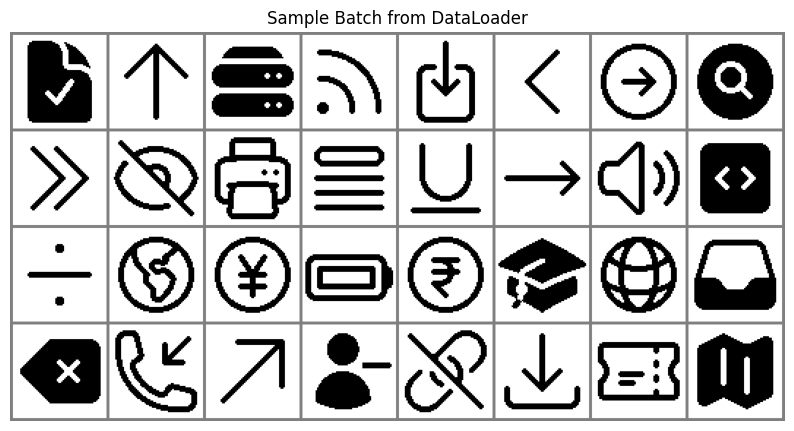

In [ ]:

def imshow(img_tensor, title=None):
    """display a batch of images"""
    img_tensor = img_tensor.cpu() # Move tensor to CPU
    # Make a grid (normalize=True scales images to [0,1])
    grid_img = make_grid(img_tensor, nrow=8, normalize=True, pad_value=0.5)
    # Convert to numpy and transpose axes for matplotlib
    npimg = grid_img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

print(train_loader)
# Fetch one batch of images
try:
    sample_batch = next(iter(train_loader))
    logging.info(f"Sample batch loaded, shape: {sample_batch.shape}")
    imshow(sample_batch, title="Sample Batch from DataLoader")
except Exception as e:
    logging.error(f"Error fetching/displaying sample batch: {e}")


### VAE Model Architecture

This defines the structure of our Variational Autoencoder using PyTorch's `nn.Module`. It consists of:
1.  **Encoder:** Convolutional layers to compress the image into latent parameters (`mu` and `logvar`).
2.  **Reparameterization Trick:** To sample from the latent distribution differentiably.
3.  **Decoder:** Transposed convolutional layers to reconstruct the image from a latent vector.


In [16]:

# VAE Model Architecture
class VAE(nn.Module):
    def __init__(self, img_channels=1, latent_dim=32, hidden_dims=None, img_size=64):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.img_channels = img_channels

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        modules = []
        in_channels = img_channels

        logging.info("Building Encoder...")
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            logging.info(f" Added Encoder Conv layer: out_channels={h_dim}, stride=2")

        self.encoder = nn.Sequential(*modules)

        # Calculate the flattened size after convolutions
        self.final_conv_size = img_size // (2**len(hidden_dims))
        if self.final_conv_size <= 0:
             raise ValueError(f"Image size {img_size} too small for {len(hidden_dims)} encoding layers. Reduce layers or increase image size.")
        self.flattened_size = hidden_dims[-1] * (self.final_conv_size ** 2)
        logging.info(f" Encoder output feature map size: {hidden_dims[-1]} x {self.final_conv_size} x {self.final_conv_size}")
        logging.info(f" Flattened size before latent layers: {self.flattened_size}")

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        logging.info(f" Latent dimension: {latent_dim}")

        logging.info("Building Decoder...")
        modules = []
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        logging.info(f" Decoder input layer reshapes latent dim to: {self.flattened_size}")


        decoder_hidden_dims = hidden_dims.copy()
        decoder_hidden_dims.reverse() # Reverse for decoder construction [256, 128, 64, 32]

        # Input to first Transposed Conv layer
        in_channels = decoder_hidden_dims[0] # e.g., 256

        for i in range(len(decoder_hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels,
                                       decoder_hidden_dims[i+1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1), # Upsamples by 2
                    nn.BatchNorm2d(decoder_hidden_dims[i+1]),
                    nn.LeakyReLU())
            )
            logging.info(f" Added Decoder Transposed Conv layer: out_channels={decoder_hidden_dims[i+1]}, stride=2")
            in_channels = decoder_hidden_dims[i+1] # Update in_channels for next layer

        self.decoder = nn.Sequential(*modules)

        # reconstruct the image
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(decoder_hidden_dims[-1], # Last hidden dim (e.g., 32)
                                               decoder_hidden_dims[-1], # Intermediate channels
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(decoder_hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(decoder_hidden_dims[-1], out_channels=img_channels, # Output channels
                                      kernel_size=3, padding=1),
                            nn.Sigmoid()) # Sigmoid to output values between 0 and 1
        logging.info(f" Added Final Decoder Layer: output channels={img_channels}")
        logging.info(" VAE Architecture Build Complete.")


    def encode(self, x):
        """Encodes input image x to latent space parameters mu and logvar."""
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon."""
        std = torch.exp(0.5 * logvar) # std = sqrt(variance) = exp(0.5 * log(variance))
        eps = torch.randn_like(std) # Sample epsilon from N(0, 1)
        return mu + eps * std

    def decode(self, z):
        """Decodes latent vector z back into an image."""
        result = self.decoder_input(z)
        # Reshape to match the shape before flattening in the encoder
        # Shape: [Batch, Channels, Height, Width]
        result = result.view(-1, HIDDEN_DIMS[-1], self.final_conv_size, self.final_conv_size)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, x):
        """Full forward pass: Encode -> Reparameterize -> Decode."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

# Instantiate Model and Optimizer
logging.info("Initializing VAE model...")
model = VAE(img_channels=IMG_CHANNELS,
            latent_dim=LATENT_DIM,
            hidden_dims=HIDDEN_DIMS,
            img_size=IMG_SIZE).to(DEVICE)

logging.info("Initializing Optimizer...")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# W&B Model Watching
wandb.watch(model, log='gradients', log_freq=100) # Log gradients every 100 batches

logging.info(f"Model overview:\n{model}")


2025-05-04 01:18:10,590 - INFO - Initializing VAE model...
2025-05-04 01:18:10,592 - INFO - Building Encoder...
2025-05-04 01:18:10,594 - INFO -  Added Encoder Conv layer: out_channels=32, stride=2
2025-05-04 01:18:10,595 - INFO -  Added Encoder Conv layer: out_channels=64, stride=2
2025-05-04 01:18:10,596 - INFO -  Added Encoder Conv layer: out_channels=128, stride=2
2025-05-04 01:18:10,597 - INFO -  Added Encoder Conv layer: out_channels=256, stride=2
2025-05-04 01:18:10,597 - INFO -  Encoder output feature map size: 256 x 4 x 4
2025-05-04 01:18:10,597 - INFO -  Flattened size before latent layers: 4096
2025-05-04 01:18:10,599 - INFO -  Latent dimension: 32
2025-05-04 01:18:10,600 - INFO - Building Decoder...
2025-05-04 01:18:10,601 - INFO -  Decoder input layer reshapes latent dim to: 4096
2025-05-04 01:18:10,603 - INFO -  Added Decoder Transposed Conv layer: out_channels=128, stride=2
2025-05-04 01:18:10,604 - INFO -  Added Decoder Transposed Conv layer: out_channels=64, stride=2
2


### VAE Loss Function

The VAE loss combines two terms:
1.  **Reconstruction Loss:** How well the decoded image matches the original input. We use Binary Cross-Entropy (BCE) since our output is sigmoid-activated (values between 0 and 1), suitable for binary or normalized grayscale images.
2.  **KL Divergence Loss:** A regularizer that measures how much the learned latent distribution (for each input) deviates from a standard normal distribution (mean 0, variance 1). This encourages a smooth and structured latent space.

The `beta` parameter allows weighting the KL term (Beta-VAE). `beta=1` is a standard VAE.


In [17]:

#VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    Calculates VAE loss: Reconstruction Loss + Beta * KL Divergence
    recon_x: reconstructed input [Batch, Channels, H, W]
    x: original input [Batch, Channels, H, W]
    mu: latent mean [Batch, LatentDim]
    logvar: latent log variance [Batch, LatentDim]
    beta: weight for KL divergence term
    """
    # Reconstruction Loss (Binary Cross Entropy)
    # Sum over all pixels, then average over the batch
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.shape[0] # Average per image in batch

    # KL Divergence (analytical solution for Gaussian N(mu, var) vs N(0, 1))
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2) per sample
    # Average over the batch
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1) # Sum over latent dims
    KLD = torch.mean(KLD, dim=0) # Average over batch dimension

    # Total Loss
    total_loss = BCE + beta * KLD
    return total_loss, BCE, KLD


## Phase 3: Training the VAE

This is the main training loop where we iterate over the dataset for a number of epochs, calculate the loss, and update the model's weights using the optimizer. We log the progress and sample outputs to Weights & Biases.


In [18]:

# Training Loop
logging.info("Starting training...")

# Keep track of fixed input samples for consistent visualization
try:
    fixed_input_sample = next(iter(train_loader)).to(DEVICE)
    logging.info(f"Using fixed sample batch of size {fixed_input_sample.shape[0]} for visualization.")
except StopIteration:
    logging.warning("DataLoader empty, cannot get fixed sample for visualization.")
    fixed_input_sample = None
except Exception as e:
    logging.error(f"Error getting fixed sample: {e}")
    fixed_input_sample = None


for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    train_loss= 0
    recon_loss_epoch= 0
    kld_loss_epoch = 0

    # Use tqdm for a progress bar over batches
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, data in pbar:
        data = data.to(DEVICE) # Move data to GPU/CPU

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Calculate loss
        loss, recon_loss, kld_loss = vae_loss_function(recon_batch, data, mu, logvar, beta=BETA)

        # Backward pass and optimize
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update weights

        # Accumulate losses for epoch average
        train_loss += loss.item()
        recon_loss_epoch += recon_loss.item()
        kld_loss_epoch += kld_loss.item()

        # Update progress bar description
        pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'BCE': f"{recon_loss.item():.4f}",
            'KLD': f"{kld_loss.item():.4f}"
        })

    # Calculate average losses for the epoch
    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss_epoch / len(train_loader)
    avg_kld_loss = kld_loss_epoch / len(train_loader)

    logging.info(f"====> Epoch: {epoch+1} Average loss: {avg_loss:.4f} (BCE: {avg_recon_loss:.4f}, KLD: {avg_kld_loss:.4f})")

    # Logging to Weights & Biases
    log_dict = {
        "epoch": epoch + 1,
        "train/loss": avg_loss,
        "train/recon_loss": avg_recon_loss,
        "train/kld_loss": avg_kld_loss,
    }

    # Generate and log sample reconstructions and random generations
    model.eval() # evaluation mode for generation
    with torch.no_grad(): # No need to track gradients here
        # 1. Reconstructions of fixed samples
        if fixed_input_sample is not None:
            recon_fixed, _, _ = model(fixed_input_sample)
            comparison = torch.cat([fixed_input_sample, recon_fixed])

            save_image(comparison.cpu(),
                       os.path.join(RESULTS_DIR, f'reconstruction_epoch_{epoch+1}.png'),
                       nrow=fixed_input_sample.shape[0])

            log_dict["train/reconstructions"] = wandb.Image(comparison.cpu(),
                                                            caption=f"Epoch {epoch+1}: Top=Original, Bottom=Reconstruction")

        # 2. Generate images from random latent vectors
        num_samples_to_gen = BATCH_SIZE # Generate a batch size worth of samples
        # Sample z from standard normal distribution N(0, I)
        random_z = torch.randn(num_samples_to_gen, LATENT_DIM).to(DEVICE)
        generated_samples = model.decode(random_z)

        save_image(generated_samples.cpu(),
                   os.path.join(RESULTS_DIR, f'generated_sample_epoch_{epoch+1}.png'),
                   nrow=8)

        log_dict["train/generated_samples"] = wandb.Image(generated_samples.cpu(),
                                                         caption=f"Epoch {epoch+1}: Randomly Generated Samples")

    wandb.log(log_dict)

logging.info("--- Training Finished ---")


2025-05-04 01:18:25,294 - INFO - Starting training...
2025-05-04 01:18:25,312 - INFO - Using fixed sample batch of size 32 for visualization.


Epoch 1/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:28,030 - INFO - ====> Epoch: 1 Average loss: 1989.0566 (BCE: 1957.7305, KLD: 31.3261)
2025-05-04 01:18:29,435 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-04 01:18:29,436 - INFO - NumExpr defaulting to 8 threads.


Epoch 2/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:32,829 - INFO - ====> Epoch: 2 Average loss: 1340.3427 (BCE: 1277.5739, KLD: 62.7687)


Epoch 3/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:35,609 - INFO - ====> Epoch: 3 Average loss: 1106.8375 (BCE: 1035.2396, KLD: 71.5979)


Epoch 4/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:38,270 - INFO - ====> Epoch: 4 Average loss: 956.4183 (BCE: 877.8275, KLD: 78.5908)


Epoch 5/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:41,006 - INFO - ====> Epoch: 5 Average loss: 866.7910 (BCE: 784.1037, KLD: 82.6873)


Epoch 6/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:43,641 - INFO - ====> Epoch: 6 Average loss: 780.2065 (BCE: 693.7698, KLD: 86.4367)


Epoch 7/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:46,517 - INFO - ====> Epoch: 7 Average loss: 705.2693 (BCE: 620.8467, KLD: 84.4226)


Epoch 8/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:49,440 - INFO - ====> Epoch: 8 Average loss: 648.6755 (BCE: 560.6394, KLD: 88.0362)


Epoch 9/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:52,230 - INFO - ====> Epoch: 9 Average loss: 616.5821 (BCE: 528.9379, KLD: 87.6441)


Epoch 10/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:54,926 - INFO - ====> Epoch: 10 Average loss: 592.3632 (BCE: 502.5369, KLD: 89.8263)


Epoch 11/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:18:57,582 - INFO - ====> Epoch: 11 Average loss: 535.2220 (BCE: 446.3975, KLD: 88.8244)


Epoch 12/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:00,324 - INFO - ====> Epoch: 12 Average loss: 524.4621 (BCE: 436.3759, KLD: 88.0863)


Epoch 13/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:03,356 - INFO - ====> Epoch: 13 Average loss: 480.2606 (BCE: 392.5926, KLD: 87.6680)


Epoch 14/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:06,041 - INFO - ====> Epoch: 14 Average loss: 450.7591 (BCE: 364.3985, KLD: 86.3606)


Epoch 15/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:08,797 - INFO - ====> Epoch: 15 Average loss: 423.2697 (BCE: 337.7308, KLD: 85.5389)


Epoch 16/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:11,579 - INFO - ====> Epoch: 16 Average loss: 407.1837 (BCE: 324.5767, KLD: 82.6070)


Epoch 17/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:14,624 - INFO - ====> Epoch: 17 Average loss: 408.3005 (BCE: 320.5097, KLD: 87.7908)


Epoch 18/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:17,420 - INFO - ====> Epoch: 18 Average loss: 380.3135 (BCE: 295.6505, KLD: 84.6631)


Epoch 19/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:20,624 - INFO - ====> Epoch: 19 Average loss: 346.5326 (BCE: 264.0145, KLD: 82.5181)


Epoch 20/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:23,448 - INFO - ====> Epoch: 20 Average loss: 334.6490 (BCE: 253.3005, KLD: 81.3484)


Epoch 21/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:26,086 - INFO - ====> Epoch: 21 Average loss: 314.0671 (BCE: 234.4831, KLD: 79.5840)


Epoch 22/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:28,797 - INFO - ====> Epoch: 22 Average loss: 298.1669 (BCE: 219.1549, KLD: 79.0120)


Epoch 23/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:31,466 - INFO - ====> Epoch: 23 Average loss: 283.7732 (BCE: 205.9722, KLD: 77.8010)


Epoch 24/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:34,139 - INFO - ====> Epoch: 24 Average loss: 302.6484 (BCE: 222.3076, KLD: 80.3409)


Epoch 25/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:36,821 - INFO - ====> Epoch: 25 Average loss: 306.3770 (BCE: 225.3936, KLD: 80.9834)


Epoch 26/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:39,502 - INFO - ====> Epoch: 26 Average loss: 311.6717 (BCE: 232.2967, KLD: 79.3751)


Epoch 27/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:42,125 - INFO - ====> Epoch: 27 Average loss: 305.0532 (BCE: 222.4796, KLD: 82.5736)


Epoch 28/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:44,762 - INFO - ====> Epoch: 28 Average loss: 264.4493 (BCE: 186.5519, KLD: 77.8975)


Epoch 29/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:47,473 - INFO - ====> Epoch: 29 Average loss: 253.8523 (BCE: 176.1901, KLD: 77.6621)


Epoch 30/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:50,132 - INFO - ====> Epoch: 30 Average loss: 236.2355 (BCE: 161.9065, KLD: 74.3290)


Epoch 31/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:53,132 - INFO - ====> Epoch: 31 Average loss: 227.5712 (BCE: 152.8679, KLD: 74.7034)


Epoch 32/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:55,942 - INFO - ====> Epoch: 32 Average loss: 251.3652 (BCE: 175.0252, KLD: 76.3400)


Epoch 33/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:19:58,794 - INFO - ====> Epoch: 33 Average loss: 233.3155 (BCE: 157.2194, KLD: 76.0961)


Epoch 34/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:01,488 - INFO - ====> Epoch: 34 Average loss: 228.4150 (BCE: 153.8864, KLD: 74.5287)


Epoch 35/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:04,151 - INFO - ====> Epoch: 35 Average loss: 221.3331 (BCE: 146.5114, KLD: 74.8217)


Epoch 36/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:06,854 - INFO - ====> Epoch: 36 Average loss: 205.3358 (BCE: 133.9014, KLD: 71.4343)


Epoch 37/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:09,535 - INFO - ====> Epoch: 37 Average loss: 193.6704 (BCE: 122.6097, KLD: 71.0607)


Epoch 38/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:12,182 - INFO - ====> Epoch: 38 Average loss: 191.7519 (BCE: 120.5962, KLD: 71.1556)


Epoch 39/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:14,822 - INFO - ====> Epoch: 39 Average loss: 185.6976 (BCE: 113.5370, KLD: 72.1606)


Epoch 40/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:17,466 - INFO - ====> Epoch: 40 Average loss: 185.7835 (BCE: 115.3111, KLD: 70.4723)


Epoch 41/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:20,540 - INFO - ====> Epoch: 41 Average loss: 187.5236 (BCE: 115.8122, KLD: 71.7114)


Epoch 42/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:23,375 - INFO - ====> Epoch: 42 Average loss: 198.2106 (BCE: 126.3771, KLD: 71.8335)


Epoch 43/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:26,083 - INFO - ====> Epoch: 43 Average loss: 229.9635 (BCE: 156.4119, KLD: 73.5515)


Epoch 44/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:28,877 - INFO - ====> Epoch: 44 Average loss: 209.4592 (BCE: 135.3033, KLD: 74.1559)


Epoch 45/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:31,622 - INFO - ====> Epoch: 45 Average loss: 192.4420 (BCE: 121.1813, KLD: 71.2607)


Epoch 46/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:34,306 - INFO - ====> Epoch: 46 Average loss: 177.5050 (BCE: 108.4593, KLD: 69.0456)


Epoch 47/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:36,969 - INFO - ====> Epoch: 47 Average loss: 174.3637 (BCE: 104.2035, KLD: 70.1602)


Epoch 48/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:39,653 - INFO - ====> Epoch: 48 Average loss: 172.7644 (BCE: 102.0526, KLD: 70.7119)


Epoch 49/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:42,344 - INFO - ====> Epoch: 49 Average loss: 182.5796 (BCE: 113.6504, KLD: 68.9292)


Epoch 50/50:   0%|          | 0/21 [00:00<?, ?it/s]

2025-05-04 01:20:44,986 - INFO - ====> Epoch: 50 Average loss: 195.0712 (BCE: 123.7691, KLD: 71.3021)
2025-05-04 01:20:45,123 - INFO - --- Training Finished ---


## Phase 4: Saving, Loading, and Exploration

Now that the model is trained, we'll save its state (weights) so we can load it later without retraining. Then, we'll explore the learned latent space.
### Save the Trained Model

We save the model's `state_dict`, which contains all the learned weights and biases.


In [19]:
# Save Model
logging.info(f"Saving model state dictionary to: {MODEL_SAVE_PATH}")
try:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    logging.info("Model saved successfully.")

except Exception as e:
    logging.error(f"Error saving model: {e}")


2025-05-04 01:20:50,309 - INFO - Saving model state dictionary to: vae_heroicons_model.pth
2025-05-04 01:20:50,328 - INFO - Model saved successfully.



### Load the Trained Model

To perform exploration or use the model later, we first need to load the saved weights back into the model structure. **Important:** You need to have the same `VAE` class definition available as when you saved the model.


In [20]:

# Load Model
# (Ensure parameters like LATENT_DIM, HIDDEN_DIMS match the saved model)
logging.info("Creating new model instance for loading...")
loaded_model = VAE(img_channels=IMG_CHANNELS,
                   latent_dim=LATENT_DIM,
                   hidden_dims=HIDDEN_DIMS,
                   img_size=IMG_SIZE).to(DEVICE)

# Load the saved state dictionary
logging.info(f"Loading model state dictionary from: {MODEL_SAVE_PATH}")
try:
    loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    loaded_model.eval() # Set to evaluation mode (disables dropout, batchnorm updates)
    logging.info("Model loaded successfully and set to evaluation mode.")
except FileNotFoundError:
    logging.error(f"Model file not found at {MODEL_SAVE_PATH}. Cannot load.")
except Exception as e:
    logging.error(f"Error loading model state_dict: {e}")


2025-05-04 01:21:01,885 - INFO - Creating new model instance for loading...
2025-05-04 01:21:01,886 - INFO - Building Encoder...
2025-05-04 01:21:01,891 - INFO -  Added Encoder Conv layer: out_channels=32, stride=2
2025-05-04 01:21:01,892 - INFO -  Added Encoder Conv layer: out_channels=64, stride=2
2025-05-04 01:21:01,893 - INFO -  Added Encoder Conv layer: out_channels=128, stride=2
2025-05-04 01:21:01,895 - INFO -  Added Encoder Conv layer: out_channels=256, stride=2
2025-05-04 01:21:01,896 - INFO -  Encoder output feature map size: 256 x 4 x 4
2025-05-04 01:21:01,896 - INFO -  Flattened size before latent layers: 4096
2025-05-04 01:21:01,898 - INFO -  Latent dimension: 32
2025-05-04 01:21:01,899 - INFO - Building Decoder...
2025-05-04 01:21:01,900 - INFO -  Decoder input layer reshapes latent dim to: 4096
2025-05-04 01:21:01,902 - INFO -  Added Decoder Transposed Conv layer: out_channels=128, stride=2
2025-05-04 01:21:01,903 - INFO -  Added Decoder Transposed Conv layer: out_channe


### Latent Space Exploration 1: Generating New Icons

We can generate novel icons by sampling random vectors from the prior distribution (standard normal N(0,1)) and decoding them using the trained decoder.


2025-05-04 01:21:10,580 - INFO - Generating new icons from random latent vectors...


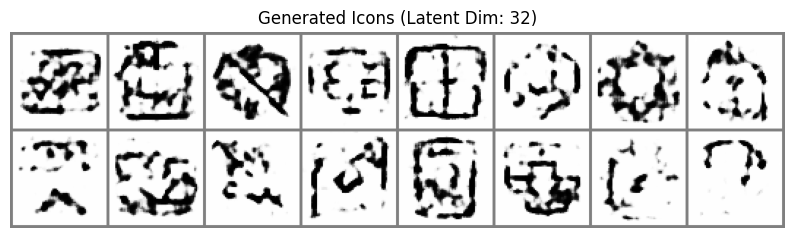

2025-05-04 01:21:10,870 - INFO - Saved generated samples grid to vae_results/final_generated_samples.png


In [21]:

# Generate New Icons
if 'loaded_model' in locals() and loaded_model is not None:
    logging.info("Generating new icons from random latent vectors...")
    num_generate = 16
    with torch.no_grad():
        # Sample random z vectors
        random_z = torch.randn(num_generate, LATENT_DIM).to(DEVICE)
        # Decode them
        generated_images = loaded_model.decode(random_z)

    # Visualize the generated images
    imshow(generated_images, title=f"Generated Icons (Latent Dim: {LATENT_DIM})")

    save_image(generated_images.cpu(), os.path.join(RESULTS_DIR, 'final_generated_samples.png'), nrow=4)
    logging.info(f"Saved generated samples grid to {RESULTS_DIR}/final_generated_samples.png")
else:
    logging.warning("Model not loaded successfully, skipping generation.")



# Latent space exploration
Trying to do Average, sum, subtraction on existing icons

2025-05-04 01:25:37,924 - INFO - Performing latent space arithmetic (averaging two icons)...


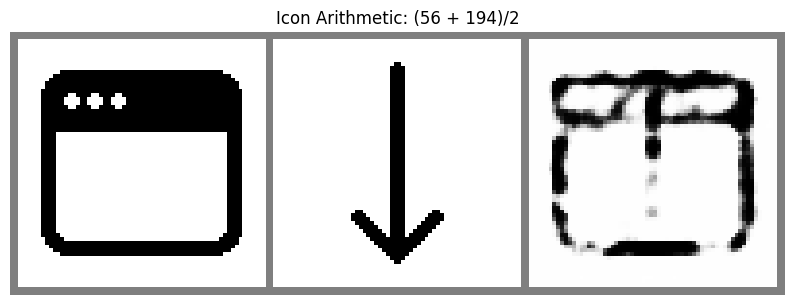

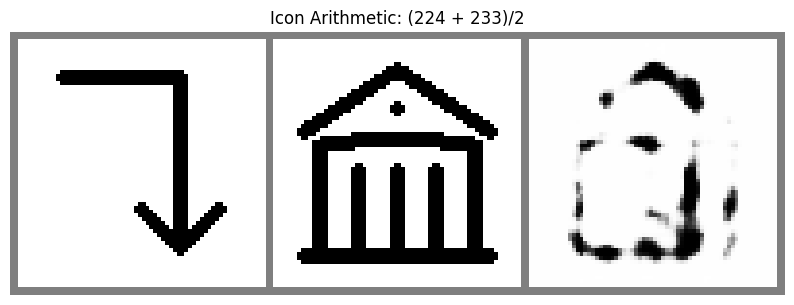

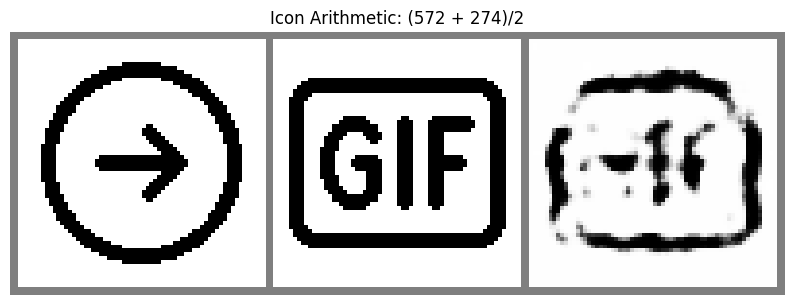

2025-05-04 01:25:38,183 - INFO - Saved 30 icon arithmetic results to vae_results/icon_arithmetic


In [26]:
#Latent Space Arithmetic
if 'loaded_model' in locals() and loaded_model is not None and len(dataset) >= 20:
    logging.info("Performing latent space arithmetic (averaging two icons)...")
    
    # Create directory for icon arithmetic results if it doesn't exist
    arithmetic_dir = os.path.join(RESULTS_DIR, 'icon_mean')
    os.makedirs(arithmetic_dir, exist_ok=True)
    
    # Number of icon pairs to combine
    num_combinations = 30
    
    # Select random pairs of icons
    all_indices = np.random.choice(len(dataset), num_combinations * 2, replace=False)
    
    for i in range(num_combinations):
        # Get indices for this pair
        idx1, idx2 = all_indices[i*2], all_indices[i*2+1]
        
        # Get the two images
        img1 = dataset[idx1].unsqueeze(0).to(DEVICE)  # Add batch dimension
        img2 = dataset[idx2].unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            # Encode both images to get their latent means
            mu1, logvar1 = loaded_model.encode(img1)
            mu2, logvar2 = loaded_model.encode(img2)
            
            # Average the latent vectors
            avg_mu = (mu1 + mu2) / 2
            
            # Decode the averaged latent vector
            avg_image = loaded_model.decode(avg_mu)
            
            # Create a grid with the original images and the result
            comparison = torch.cat([img1, img2, avg_image])
            
            # Save the comparison
            save_path = os.path.join(arithmetic_dir, f'icon_avg_{idx1}_{idx2}.png')
            save_image(comparison.cpu(), save_path, nrow=3)
            
            # Also visualize the first few combinations
            if i < 3:  # Show only the first 3 to avoid cluttering the notebook
                imshow(comparison, title=f"Icon Arithmetic: ({idx1} + {idx2})/2")
    
    logging.info(f"Saved {num_combinations} icon arithmetic results to {arithmetic_dir}")
else:
    logging.warning("Model not loaded or dataset has < 20 images, skipping icon arithmetic.")


2025-05-04 01:30:42,180 - INFO - Performing latent space arithmetic (averaging two icons)...


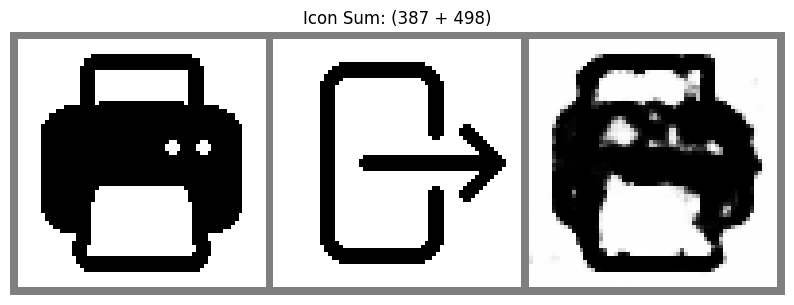

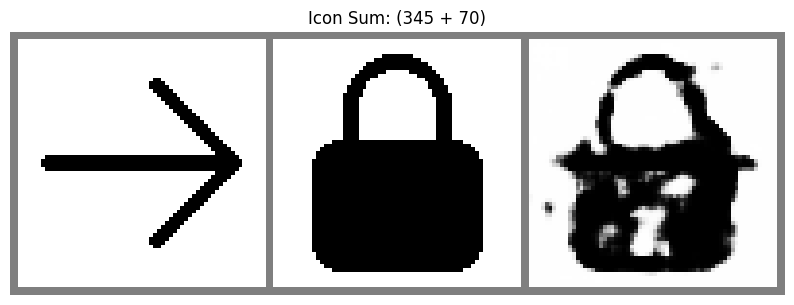

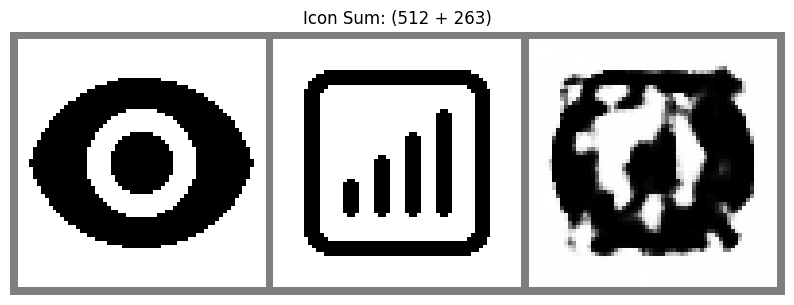

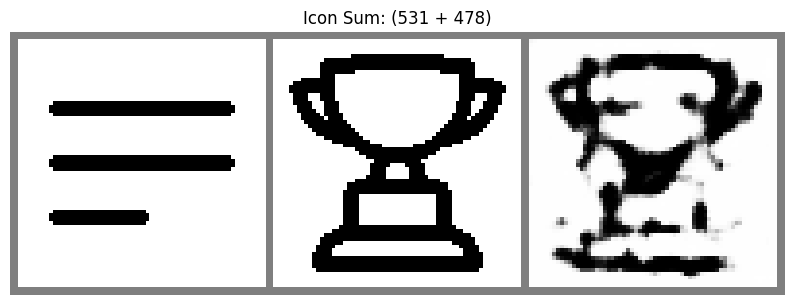

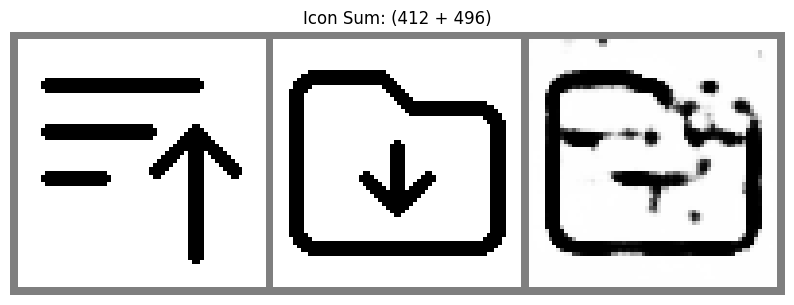

2025-05-04 01:30:42,465 - INFO - Saved 10 icon sum results to vae_results/icon_sum


In [27]:
#Latent Space Summation
if 'loaded_model' in locals() and loaded_model is not None and len(dataset) >= 20:
    logging.info("Performing latent space arithmetic (averaging two icons)...")
    
    # Create directory for icon sum results if it doesn't exist
    sum_dir = os.path.join(RESULTS_DIR, 'icon_sum')
    os.makedirs(sum_dir, exist_ok=True)
    
    # Number of icon pairs to combine
    num_combinations = 10
    
    # Select random pairs of icons
    all_indices = np.random.choice(len(dataset), num_combinations * 2, replace=False)
    
    for i in range(num_combinations):
        # Get indices for this pair
        idx1, idx2 = all_indices[i*2], all_indices[i*2+1]
        
        # Get the two images
        img1 = dataset[idx1].unsqueeze(0).to(DEVICE)  # Add batch dimension
        img2 = dataset[idx2].unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            # Encode both images to get their latent means
            mu1, logvar1 = loaded_model.encode(img1)
            mu2, logvar2 = loaded_model.encode(img2)
            
            # Sum the latent vectors
            avg_mu = (mu1 + mu2) 
            
            # Decode the averaged latent vector
            avg_image = loaded_model.decode(avg_mu)
            
            # Create a grid with the original images and the result
            comparison = torch.cat([img1, img2, avg_image])
            
            # Save the comparison
            save_path = os.path.join(sum_dir, f'icon_avg_{idx1}_{idx2}.png')
            save_image(comparison.cpu(), save_path, nrow=3)
            
            # Also visualize the first few combinations
            if i < 5:  # Show only the first 3 to avoid cluttering the notebook
                imshow(comparison, title=f"Icon Sum: ({idx1} + {idx2})")
    
    logging.info(f"Saved {num_combinations} icon sum results to {sum_dir}")
else:
    logging.warning("Model not loaded or dataset has < 20 images, skipping icon arithmetic.")


2025-05-04 01:32:43,489 - INFO - Performing latent space arithmetic (averaging two icons)...


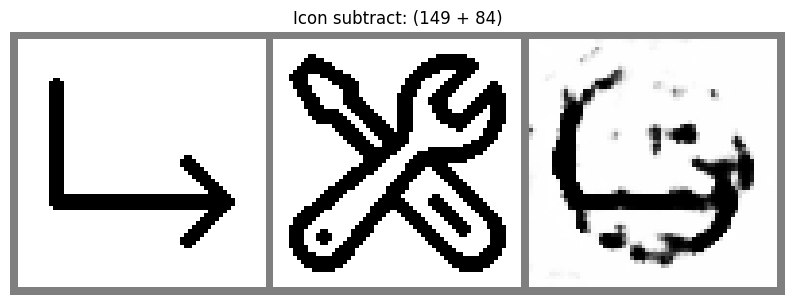

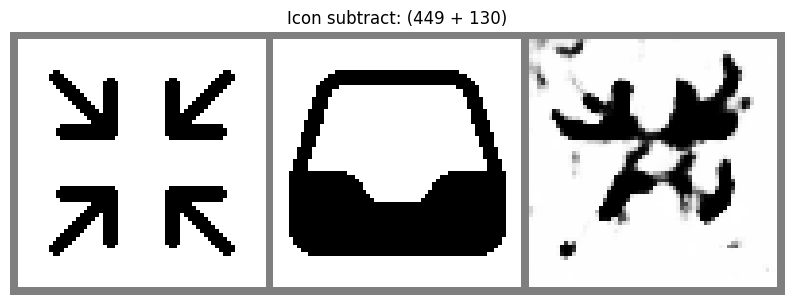

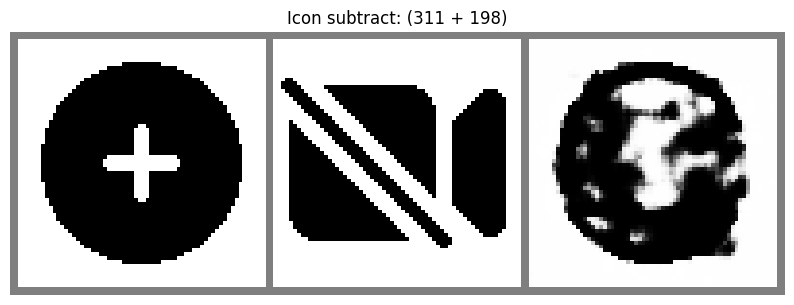

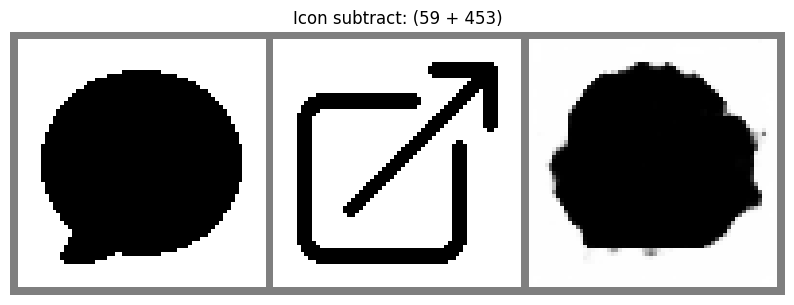

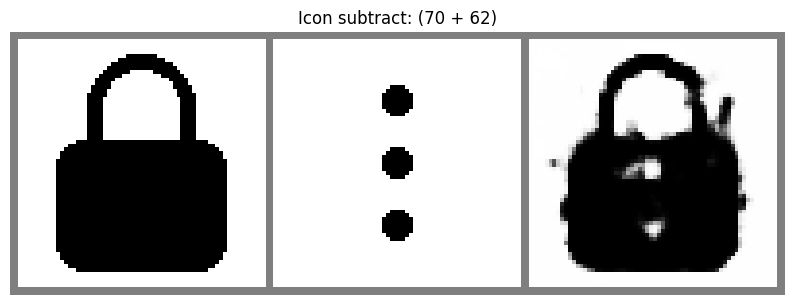

2025-05-04 01:32:43,757 - INFO - Saved 10 icon subtract results to vae_results/icon_subtract


In [28]:
#Latent Space subtraction
if 'loaded_model' in locals() and loaded_model is not None and len(dataset) >= 20:
    logging.info("Performing latent space arithmetic (averaging two icons)...")
    
    # Create directory for icon subtract results if it doesn't exist
    subtract_dir = os.path.join(RESULTS_DIR, 'icon_subtract')
    os.makedirs(subtract_dir, exist_ok=True)
    
    # Number of icon pairs to combine
    num_combinations = 10
    
    # Select random pairs of icons
    all_indices = np.random.choice(len(dataset), num_combinations * 2, replace=False)
    
    for i in range(num_combinations):
        # Get indices for this pair
        idx1, idx2 = all_indices[i*2], all_indices[i*2+1]
        
        # Get the two images
        img1 = dataset[idx1].unsqueeze(0).to(DEVICE)  # Add batch dimension
        img2 = dataset[idx2].unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            # Encode both images to get their latent means
            mu1, logvar1 = loaded_model.encode(img1)
            mu2, logvar2 = loaded_model.encode(img2)
            
            # subtract the latent vectors
            avg_mu = (mu1 - mu2) 
            
            # Decode the averaged latent vector
            avg_image = loaded_model.decode(avg_mu)
            
            # Create a grid with the original images and the result
            comparison = torch.cat([img1, img2, avg_image])
            
            # Save the comparison
            save_path = os.path.join(subtract_dir, f'icon_avg_{idx1}_{idx2}.png')
            save_image(comparison.cpu(), save_path, nrow=3)
            
            # Also visualize the first few combinations
            if i < 5:  
                imshow(comparison, title=f"Icon subtract: ({idx1} + {idx2})")
    
    logging.info(f"Saved {num_combinations} icon subtract results to {subtract_dir}")
else:
    logging.warning("Model not loaded or dataset has < 20 images, skipping icon arithmetic.")



### Latent Space Exploration 2: Reconstructing Icons

Let's pick a few icons from our dataset and see how well the loaded VAE reconstructs them. This helps verify that the loaded model works and gives a sense of the reconstruction quality.


2025-05-04 01:21:46,346 - INFO - Reconstructing sample icons from the dataset...


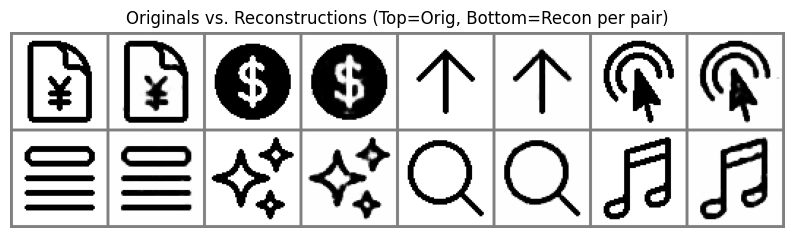

2025-05-04 01:21:46,462 - INFO - Saved reconstruction comparison grid to vae_results/final_reconstructions.png


In [22]:

#Reconstruct Icons
if 'loaded_model' in locals() and loaded_model is not None and len(dataset) > 0:
    logging.info("Reconstructing sample icons from the dataset...")
    num_reconstruct = 8 # How many icons to reconstruct
    # Get some samples from the dataset
    indices = np.random.choice(len(dataset), num_reconstruct, replace=False)
    original_images = torch.stack([dataset[i] for i in indices]).to(DEVICE)

    with torch.no_grad():
        reconstructed_images, _, _ = loaded_model(original_images)

    # Combine originals and reconstructions for comparison
    comparison_grid = torch.cat([original_images, reconstructed_images])
    # Arrange in a grid where each column is an original/reconstruction pair
    # Need to interleave them: [orig1, recon1, orig2, recon2, ...]
    interleaved_grid = torch.stack([val for pair in zip(original_images, reconstructed_images) for val in pair])


    imshow(interleaved_grid, title="Originals vs. Reconstructions (Top=Orig, Bottom=Recon per pair)")

    # Save the grid
    save_image(interleaved_grid.cpu(), os.path.join(RESULTS_DIR, 'final_reconstructions.png'), nrow=num_reconstruct)
    logging.info(f"Saved reconstruction comparison grid to {RESULTS_DIR}/final_reconstructions.png")

else:
    logging.warning("Model not loaded or dataset empty, skipping reconstruction.")



### Latent Space Exploration 3: Smooth Interpolation

This is where the magic of the VAE's smooth latent space shines. We pick two icons, encode them to get their latent representations (`mu`), and then linearly interpolate between these latent vectors. Decoding the intermediate vectors should yield a smooth visual transition between the two icons.


2025-05-05 00:44:43,572 - INFO - Performing latent space interpolation...
2025-05-05 00:44:43,583 - INFO - Pair 1/10: Interpolating between icon index 218 and 296


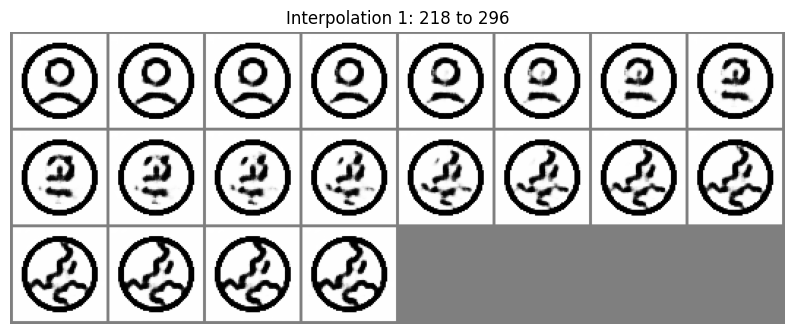

2025-05-05 00:44:43,707 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_1_218_to_296.png
2025-05-05 00:44:43,709 - INFO - Pair 2/10: Interpolating between icon index 1 and 614


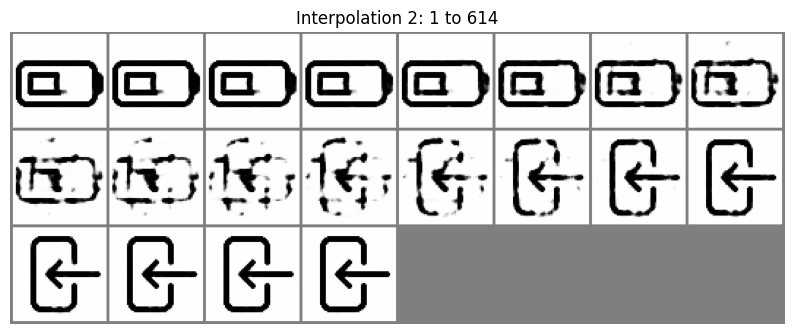

2025-05-05 00:44:43,802 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_2_1_to_614.png
2025-05-05 00:44:43,806 - INFO - Pair 3/10: Interpolating between icon index 498 and 375


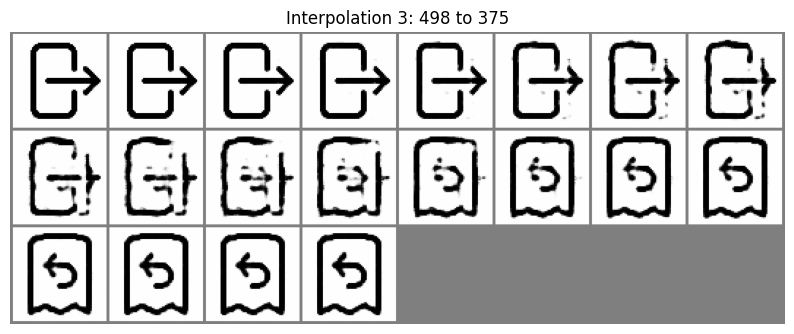

2025-05-05 00:44:43,929 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_3_498_to_375.png
2025-05-05 00:44:43,930 - INFO - Pair 4/10: Interpolating between icon index 197 and 18


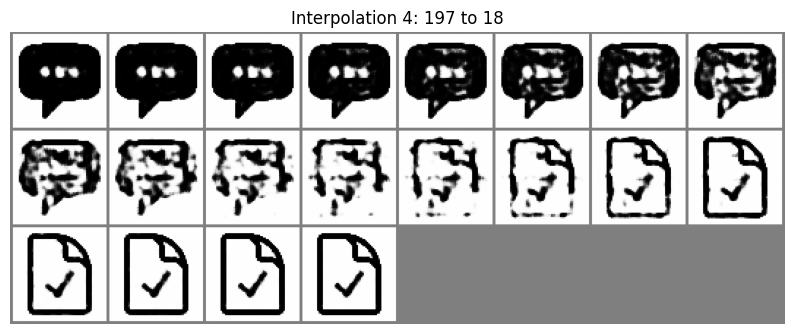

2025-05-05 00:44:44,017 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_4_197_to_18.png
2025-05-05 00:44:44,019 - INFO - Pair 5/10: Interpolating between icon index 389 and 556


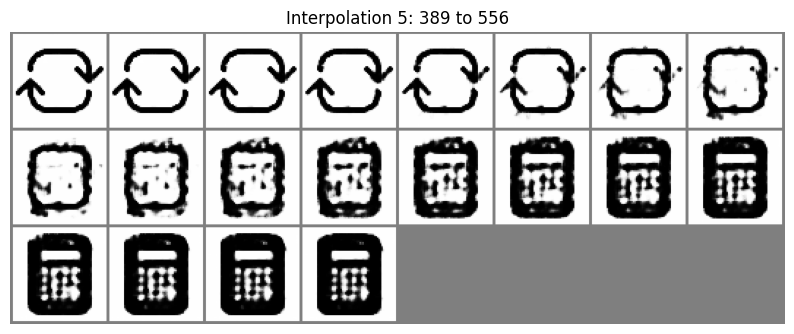

2025-05-05 00:44:44,104 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_5_389_to_556.png
2025-05-05 00:44:44,106 - INFO - Pair 6/10: Interpolating between icon index 192 and 593


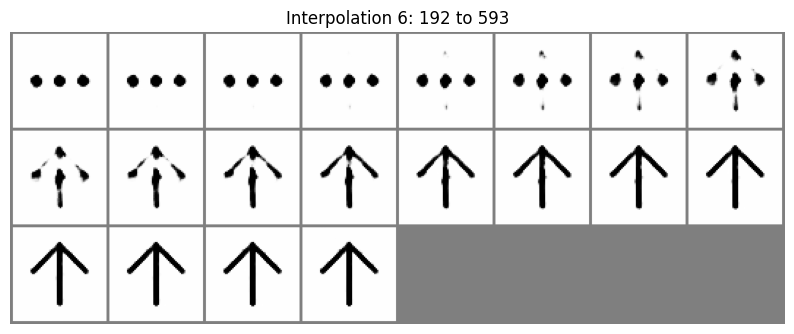

2025-05-05 00:44:44,180 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_6_192_to_593.png
2025-05-05 00:44:44,182 - INFO - Pair 7/10: Interpolating between icon index 208 and 169


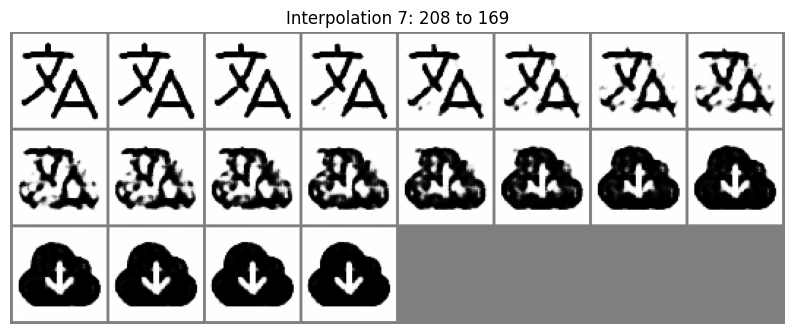

2025-05-05 00:44:44,267 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_7_208_to_169.png
2025-05-05 00:44:44,269 - INFO - Pair 8/10: Interpolating between icon index 106 and 196


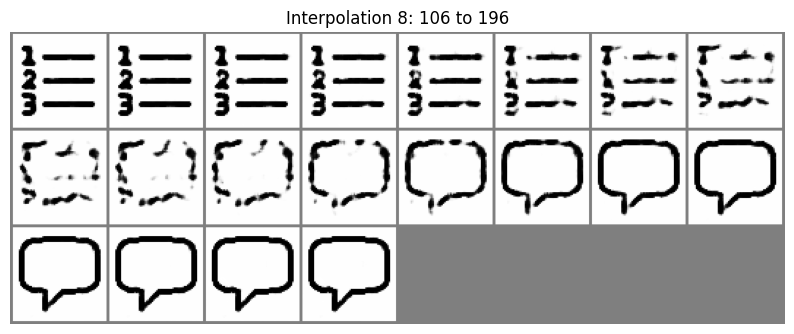

2025-05-05 00:44:44,374 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_8_106_to_196.png
2025-05-05 00:44:44,376 - INFO - Pair 9/10: Interpolating between icon index 333 and 342


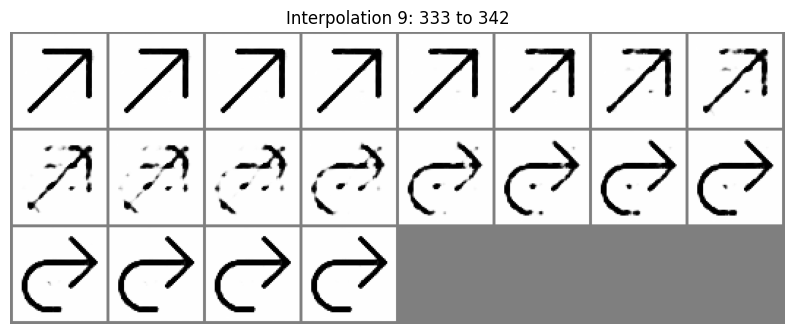

2025-05-05 00:44:44,486 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_9_333_to_342.png
2025-05-05 00:44:44,488 - INFO - Pair 10/10: Interpolating between icon index 386 and 347


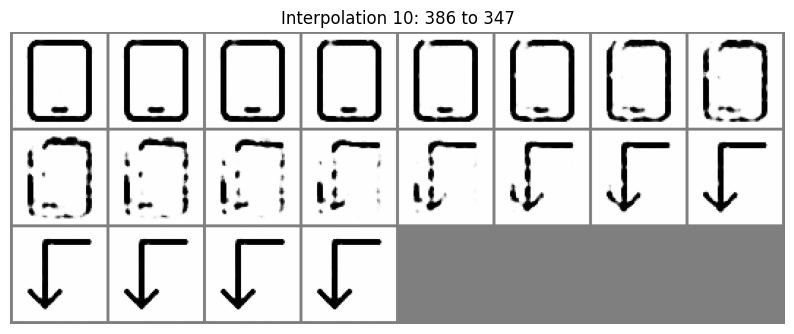

2025-05-05 00:44:44,563 - INFO - Saved interpolation grid to vae_results/interpolation/interpolation_10_386_to_347.png
2025-05-05 00:44:44,563 - INFO - Completed all 10 interpolations. Results saved to vae_results/interpolation


In [30]:
#Interpolate Between Icons
# pick 10 pairs of icons and interpolate between them and save the results in /vae_results/interpolation

if 'loaded_model' in locals() and loaded_model is not None and len(dataset) >= 2:
    logging.info("Performing latent space interpolation...")
    num_steps = 20  # Number of intermediate steps (including start and end)
    
    # Create interpolation directory if it doesn't exist
    interpolation_dir = os.path.join(RESULTS_DIR, 'interpolation')
    os.makedirs(interpolation_dir, exist_ok=True)
    
    # Generate 10 pairs of icons
    for pair_idx in range(10):
        # Select two distinct icons from the dataset
        idx1, idx2 = np.random.choice(len(dataset), 2, replace=False)
        img1 = dataset[idx1].unsqueeze(0).to(DEVICE)  # Add batch dimension
        img2 = dataset[idx2].unsqueeze(0).to(DEVICE)
        logging.info(f"Pair {pair_idx+1}/10: Interpolating between icon index {idx1} and {idx2}")

        with torch.no_grad():
            # Encode both images to get their latent means
            mu1, logvar1 = loaded_model.encode(img1)
            mu2, logvar2 = loaded_model.encode(img2)

            # Create interpolation weights (alpha from 0 to 1)
            alpha_values = torch.linspace(0, 1, num_steps).to(DEVICE)

            # Interpolate in the latent space (between the means)
            interpolated_z = []
            for alpha in alpha_values:
                z = alpha * mu2 + (1 - alpha) * mu1  # Linear interpolation
                interpolated_z.append(z)
            interpolated_z = torch.cat(interpolated_z, dim=0)  # Stack into a batch

            # Decode the interpolated latent vectors
            interpolated_images = loaded_model.decode(interpolated_z)

        # Visualize the interpolation sequence
        imshow(interpolated_images, title=f"Interpolation {pair_idx+1}: {idx1} to {idx2}")

        # Save the grid
        save_path = os.path.join(interpolation_dir, f'interpolation_{pair_idx+1}_{idx1}_to_{idx2}.png')
        save_image(interpolated_images.cpu(), save_path, nrow=num_steps)
        logging.info(f"Saved interpolation grid to {save_path}")

    logging.info(f"Completed all 10 interpolations. Results saved to {interpolation_dir}")


2025-05-07 10:45:39,125 - INFO - Setting up interactive UI for latent space operations...


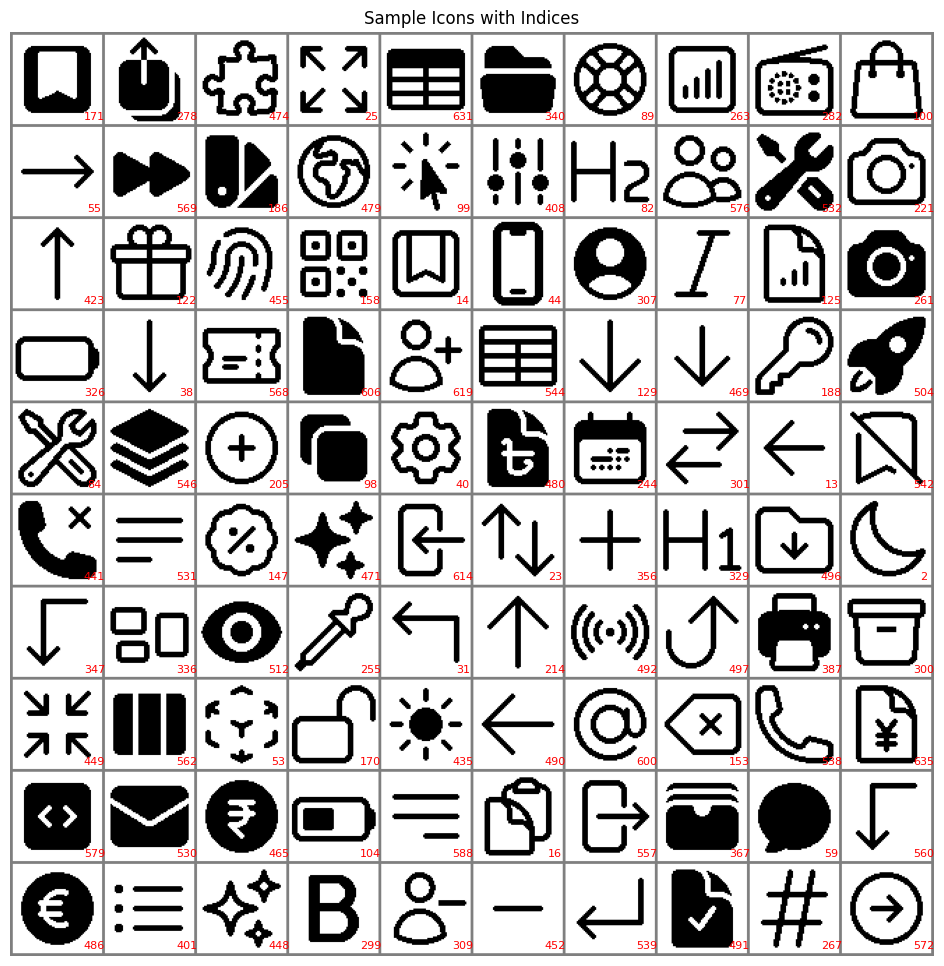

2025-05-07 10:45:39,418 - INFO - Interactive UI for latent space operations is ready.


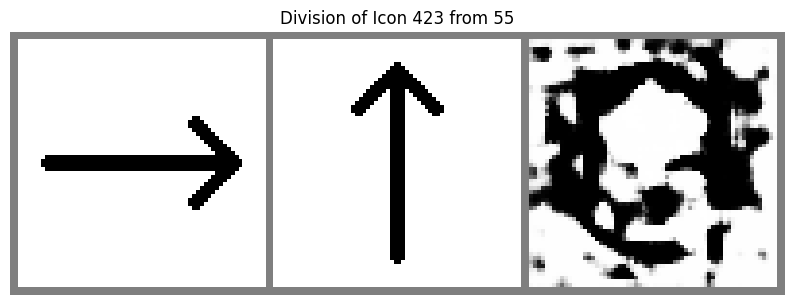

Saved result to vae_results/ui_operations/divide_55_423.png


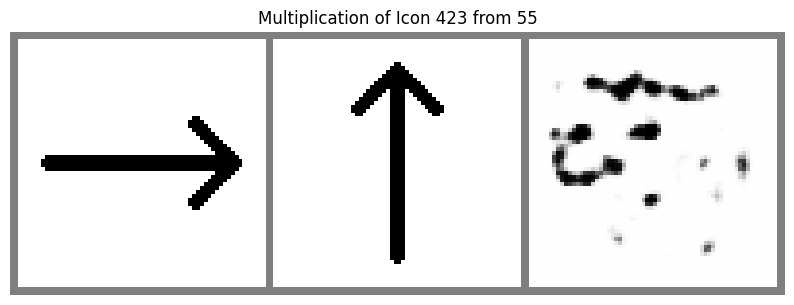

Saved result to vae_results/ui_operations/multiply_55_423.png


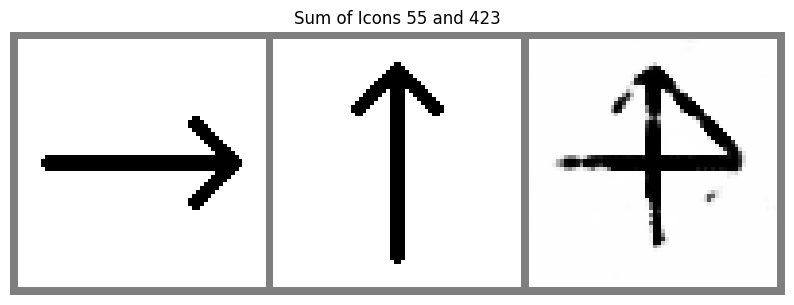

Saved result to vae_results/ui_operations/sum_55_423.png


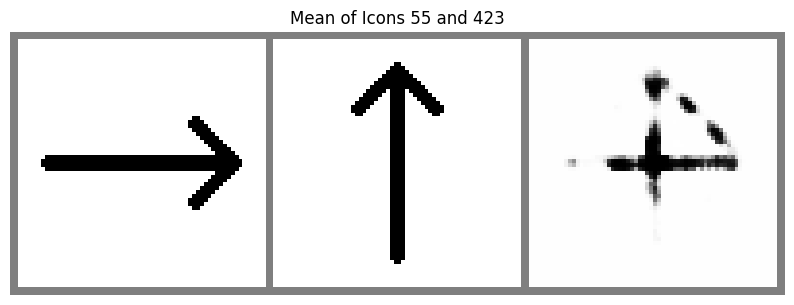

Saved result to vae_results/ui_operations/mean_55_423.png


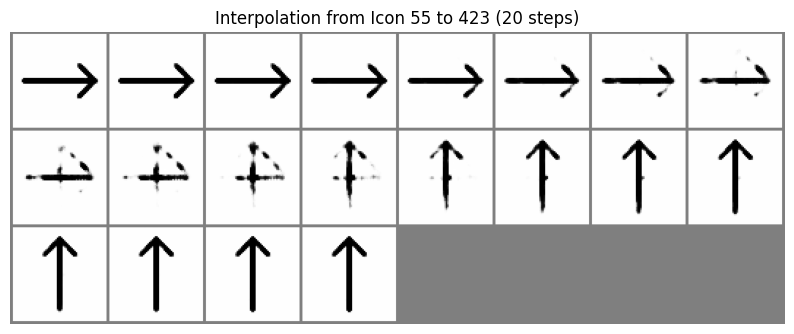

Saved result to vae_results/ui_operations/interpolate_55_to_423_20steps.png


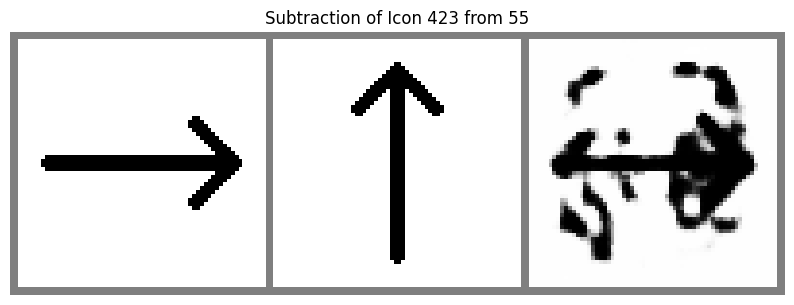

Saved result to vae_results/ui_operations/subtract_55_423.png


In [37]:
# UI to pick two icons and do operations on their vector representations like mean, sum, subtraction, interpolation

import ipywidgets as widgets
from IPython.display import display

logging.info("Setting up interactive UI for latent space operations...")

# Create directory for UI operations results if it doesn't exist
ui_results_dir = os.path.join(RESULTS_DIR, 'ui_operations')
os.makedirs(ui_results_dir, exist_ok=True)

if 'loaded_model' in locals() and loaded_model is not None and len(dataset) > 0:
    # Precompute a sample of icons to display in the UI
    num_sample_icons = min(100, len(dataset))
    sample_indices = np.random.choice(len(dataset), num_sample_icons, replace=False)
    
    # Create a grid of sample icons for preview
    sample_images = torch.stack([dataset[i] for i in sample_indices]).to(DEVICE)
    preview_grid = make_grid(sample_images, nrow=10, normalize=True, pad_value=0.5)
    preview_image = np.transpose(preview_grid.cpu().numpy(), (1, 2, 0))
    
    # Display the preview grid with indices
    plt.figure(figsize=(12, 12))
    plt.imshow(preview_image, cmap='gray')
    plt.title("Sample Icons with Indices")
    
    # Add indices as text on the image
    icon_width = preview_image.shape[1] // 10
    icon_height = preview_image.shape[0] // ((num_sample_icons + 9) // 10)
    for i, idx in enumerate(sample_indices):
        row = i // 10
        col = i % 10
        plt.text((col +1) * icon_width - icon_width // 10, 
                 (row +1) * icon_height - icon_height // 10, 
                 str(idx), 
                 color='red', 
                 fontsize=8, 
                 ha='center', 
                 va='center')
    
    plt.axis('off')
    plt.show()
    
    # Create widgets for the UI
    icon1_input = widgets.IntText(value=sample_indices[0], description='Icon 1 Index:')
    icon2_input = widgets.IntText(value=sample_indices[1], description='Icon 2 Index:')
    
    operation_dropdown = widgets.Dropdown(
        options=[('Mean', 'mean'), ('Sum', 'sum'), ('Subtraction', 'subtract'), ('Interpolation', 'interpolate'), ('Multiplication', 'multiply'), ('Division', 'divide')],
        value='mean',
        description='Operation:',
    )
    
    num_steps_slider = widgets.IntSlider(
        value=10,
        min=2,
        max=20,
        step=1,
        description='Steps:',
        disabled=False,
        continuous_update=False,
    )
    
    # Function to update UI based on selected operation
    def update_ui(change):
        if change['new'] == 'interpolate':
            num_steps_slider.layout.visibility = 'visible'
        else:
            num_steps_slider.layout.visibility = 'hidden'
    
    operation_dropdown.observe(update_ui, names='value')
    
    # Initially hide the steps slider if not interpolation
    if operation_dropdown.value != 'interpolate':
        num_steps_slider.layout.visibility = 'hidden'
    
    # Function to perform the selected operation
    def perform_operation(b):
        try:
            idx1 = int(icon1_input.value)
            idx2 = int(icon2_input.value)
            
            if idx1 < 0 or idx1 >= len(dataset) or idx2 < 0 or idx2 >= len(dataset):
                print(f"Error: Icon indices must be between 0 and {len(dataset)-1}")
                return
            
            img1 = dataset[idx1].unsqueeze(0).to(DEVICE)
            img2 = dataset[idx2].unsqueeze(0).to(DEVICE)
            
            operation = operation_dropdown.value
            
            with torch.no_grad():
                # Encode both images to get their latent means
                mu1, logvar1 = loaded_model.encode(img1)
                mu2, logvar2 = loaded_model.encode(img2)
                
                if operation == 'mean':
                    # Average the latent vectors
                    result_z = (mu1 + mu2) / 2
                    result_img = loaded_model.decode(result_z)
                    
                    # Create a grid with the original images and the result
                    comparison = torch.cat([img1, img2, result_img])
                    
                    save_path = os.path.join(ui_results_dir, f'mean_{idx1}_{idx2}.png')
                    save_image(comparison.cpu(), save_path, nrow=3)
                    
                    imshow(comparison, title=f"Mean of Icons {idx1} and {idx2}")
                    print(f"Saved result to {save_path}")
                
                elif operation == 'sum':
                    # Sum the latent vectors
                    result_z = mu1 + mu2
                    result_img = loaded_model.decode(result_z)
                    
                    # Create a grid with the original images and the result
                    comparison = torch.cat([img1, img2, result_img])
                    
                    save_path = os.path.join(ui_results_dir, f'sum_{idx1}_{idx2}.png')
                    save_image(comparison.cpu(), save_path, nrow=3)
                    
                    imshow(comparison, title=f"Sum of Icons {idx1} and {idx2}")
                    print(f"Saved result to {save_path}")
                
                elif operation == 'subtract':
                    # Subtract the latent vectors
                    result_z = mu1 - mu2
                    result_img = loaded_model.decode(result_z)
                    
                    # Create a grid with the original images and the result
                    comparison = torch.cat([img1, img2, result_img])
                    
                    save_path = os.path.join(ui_results_dir, f'subtract_{idx1}_{idx2}.png')
                    save_image(comparison.cpu(), save_path, nrow=3)
                    
                    imshow(comparison, title=f"Subtraction of Icon {idx2} from {idx1}")
                    print(f"Saved result to {save_path}")
                
                elif operation == 'interpolate':
                    num_steps = num_steps_slider.value
                    
                    # Create interpolation weights (alpha from 0 to 1)
                    alpha_values = torch.linspace(0, 1, num_steps).to(DEVICE)
                    
                    # Interpolate in the latent space
                    interpolated_z = []
                    for alpha in alpha_values:
                        z = alpha * mu2 + (1 - alpha) * mu1  # Linear interpolation
                        interpolated_z.append(z)
                    interpolated_z = torch.cat(interpolated_z, dim=0)
                    
                    interpolated_images = loaded_model.decode(interpolated_z)
                    
                    save_path = os.path.join(ui_results_dir, f'interpolate_{idx1}_to_{idx2}_{num_steps}steps.png')
                    save_image(interpolated_images.cpu(), save_path, nrow=num_steps)
                    
                    imshow(interpolated_images, title=f"Interpolation from Icon {idx1} to {idx2} ({num_steps} steps)")
                    print(f"Saved result to {save_path}")
        
                elif operation == 'multiply':
                    # multiply the latent vectors
                    result_z = mu1 * mu2
                    result_img = loaded_model.decode(result_z)
                    
                    comparison = torch.cat([img1, img2, result_img])
                    
                    save_path = os.path.join(ui_results_dir, f'multiply_{idx1}_{idx2}.png')
                    save_image(comparison.cpu(), save_path, nrow=3)
                    
                    imshow(comparison, title=f"Multiplication of Icon {idx2} from {idx1}")
                    print(f"Saved result to {save_path}")
                    
                elif operation == 'divide':
                    # divide the latent vectors
                    result_z = mu1 / mu2
                    result_img = loaded_model.decode(result_z)
                    
                    comparison = torch.cat([img1, img2, result_img])
                    
                    save_path = os.path.join(ui_results_dir, f'divide_{idx1}_{idx2}.png')
                    save_image(comparison.cpu(), save_path, nrow=3)
                    
                    imshow(comparison, title=f"Division of Icon {idx2} from {idx1}")
                    print(f"Saved result to {save_path}")
                
        except Exception as e:
            print(f"Error performing operation: {e}")
    
    # Create the button to perform the operation
    run_button = widgets.Button(description="Run Operation")
    run_button.on_click(perform_operation)
    
    # Display all the widgets
    display(widgets.VBox([
        widgets.HBox([icon1_input, icon2_input]),
        operation_dropdown,
        num_steps_slider,
        run_button
    ]))
    
    logging.info("Interactive UI for latent space operations is ready.")
else:
    logging.warning("Model not loaded or dataset empty, cannot create UI.")


In [24]:
#Finish W&B Run ---
# Important to call finish() at the end, especially in scripts/notebooks,
# to ensure all data is uploaded and the run is marked as completed.
wandb.finish()
logging.info("Weights & Biases run finished.")


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train/kld_loss,▁▅▆▇███████▇▇█▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
train/loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50


2025-05-04 01:22:15,531 - INFO - Weights & Biases run finished.
